# Generate clusterings

In [1]:
from itertools import chain, combinations

from collections import OrderedDict as odict

from math import ceil

import rdkit.Chem.Scaffolds.MurckoScaffold as MurckoScaffold

from scipy.spatial.distance import pdist

from sklearn.cluster import AffinityPropagation

from itertools import takewhile

import pickle

import seaborn as sns

from local_utils.rdkit_utils import FP

In [2]:
sns.set()

## Config

In [3]:
def get_x_matrix(df):
    
    """Create matrix of fingerprints (i.e. the X matrix)"""

    nrow, ncol, dtype = df.shape[0], FP.N_BITS, FP.DTYPE

    X = np.zeros((nrow, ncol), dtype)

    for i in range(nrow): X[i] = df['FP'][i].fp

    return np.matrix(X)

## Load actives

Get list of active parent molecules for Human targets having at least the minimium required number of actives.

In [4]:
# Actives...

actives, active_mols = pd.read_pickle('actives.pkl')

actives.shape, active_mols.shape

((167055, 2), (104749, 3))

In [5]:
actives.head(1)

,symbol,usmiles
symbol,,
ABCB1,ABCB1,C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12


,mol,FP,core_smiles
usmiles,,,
C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12,,"[0 0 0 ..., 0 0 0]",O=c1cc(-c2ccccc2)oc2ccccc12

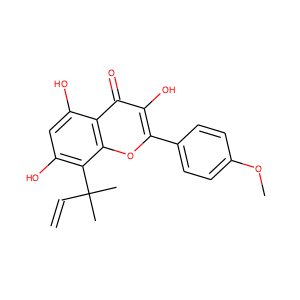

In [6]:
active_mols.head(1)

## Generate clusterings

In [11]:
clusterings = odict()

for symbol in actives['symbol'].unique():
    
    df = actives.loc[symbol].merge(active_mols, left_on='usmiles', right_index=True).drop('symbol', axis=1).set_index('usmiles')
    
    logging.info("Symbol = {}; no. actives = {}".format(symbol, df.shape[0]))
    
    # Core clusters...
    
    col = 'core'

    df[col + '_cluster'] = pd.Categorical.from_array(df['core_smiles']).categories.get_indexer(df['core_smiles']) # Add (arbitrary ) cluster number for core

    df = df.merge(df.groupby(col + '_cluster').apply(len).to_frame(name=col + '_count'), left_on=col + '_cluster', right_index=True) # Add counts for clusters
    
    logging.info("> no. {} clusters = {}".format(col, df[col + '_cluster'].unique().shape[0]))
    
    # Affiniy Propagation clusters...
    
    col = 'affinity'

    X = get_x_matrix(df)

    clustering = AffinityPropagation().fit(X)

    df[col + '_cluster'] = clustering.labels_ # Cluster numbers

    df = df.merge(df.groupby(col + '_cluster').apply(len).to_frame(name=col + '_count'), left_on=col + '_cluster', right_index=True) # Add counts for clusters
    
    logging.info("> no. {} clusters = {}".format(col, df[col + '_cluster'].unique().shape[0]))
    
    # Store...
    
    clusterings[symbol] = df.sort_index()

[2015/Aug/06 15:22:06 INFO    ] Symbol = ABCB1; no. actives = 652
[2015/Aug/06 15:22:06 INFO    ] > no. core clusters = 345
[2015/Aug/06 15:22:07 INFO    ] > no. affinity clusters = 76
[2015/Aug/06 15:22:07 INFO    ] Symbol = ABCG2; no. actives = 266
[2015/Aug/06 15:22:07 INFO    ] > no. core clusters = 85
[2015/Aug/06 15:22:07 INFO    ] > no. affinity clusters = 34
[2015/Aug/06 15:22:07 INFO    ] Symbol = ABL1; no. actives = 962
[2015/Aug/06 15:22:07 INFO    ] > no. core clusters = 493
[2015/Aug/06 15:22:08 INFO    ] > no. affinity clusters = 100
[2015/Aug/06 15:22:08 INFO    ] Symbol = ACE; no. actives = 398
[2015/Aug/06 15:22:08 INFO    ] > no. core clusters = 187
[2015/Aug/06 15:22:08 INFO    ] > no. affinity clusters = 44
[2015/Aug/06 15:22:08 INFO    ] Symbol = ACHE; no. actives = 1904
[2015/Aug/06 15:22:08 INFO    ] > no. core clusters = 950
[2015/Aug/06 15:22:20 INFO    ] > no. affinity clusters = 187
[2015/Aug/06 15:22:20 INFO    ] Symbol = ADORA1; no. actives = 2963
[2015/Aug

In [12]:
# Save...

pickle.dump(clusterings, open('clusterings.pkl', 'w'))